## Plant Seedling Image classification with Convolutional Neural Networks

####Kaggle Data Set "Plant Seedlings Classification"
https://www.kaggle.com/c/plant-seedlings-classification


In [69]:
## Check GPU memory availability

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.6 GB  | Proc size: 1.8 GB
GPU RAM Free: 11177MB | Used: 264MB | Util   2% | Total 11441MB


In [70]:
## install and setup Fast.ai v.0.7.0, pytorch and dependencies

#!pip uninstall fastai
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
!apt update && apt install -y libsm6 libxext6

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install image

%matplotlib inline
from fastai.imports import *


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
3 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsm6 is already the 

In [71]:
import sys
sys.version

'3.6.6 (default, Sep 12 2018, 18:26:19) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [72]:
import torch
print(torch.__version__)

0.3.0.post4


It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [73]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [74]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [75]:
torch.backends.cudnn.enabled

True

In [0]:
import fastai as fai

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Loading Dataset

In [79]:
#The first step is install kaggle
!pip install kaggle

In [80]:
#The second step is upload the credentials of the kaggle account.You should go to you kaggle account and to get there you apy key.You will get kaggle.json file.Then use
#the code bellow for upload that key on colab.
from google.colab import files
files.upload()

{}

In [0]:
#The third step is create some folder
#before importing the dataset we sholud use this code
#The kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#this permissions change avoids a warnong on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

In [82]:
#The forth step is get some dataset or competition or list it depends on you demands.My sample is this dataset
#!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!kaggle datasets download -d jesjutrera/stanford-car-dataset-by-classes-folder


500 - Internal Server Error


In [83]:
# since kaggle API produced Server Error, use alternative method to download data set
!curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:63.0) Gecko/20100101 Firefox/63.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --cookie '_ga=GA1.3.597929118.1540370868' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-datasets/31559/46697/stanford-car-dataset-by-classes-folder.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1541595064&Signature=i2U2xOV7K5%2FOrN6TnYkemVF4bX5cpFkUQ2iLJN9Ri8%2F5pVYSK1v1utTdd2G8pxVF5oIJkmfS7nR8rH%2FORKd4GdHJMKBFegkNdiMIaYW3xqj%2Fgcr7OOc9AsCcftCnKtIezNlOTLBbVyy52sDh12DaphjbBOh%2BhAtgkxKjkXZa1SmQEzdh8OrfILrhIeZwCza%2FrzCgNbRYH7uVVMMBwErBiIV%2FNMjTfoYnS75zZAWU8w9Sgl6Wr0YPBQOFp5MjrttWWbhxtY%2BbeFv8LHu4Q9lTx5bVarbyn2dF%2BOViJZtKECaqknceXT5Ww4MZYp158gdqegaJtx5ey9oG2yso3ejYVw%3D%3D' --output 'stanford-car-dataset-by-classes-folder.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1867M  100 1867M    0     0   139M      0  0:00:13  0:00:13 --:--:--  146M


In [84]:
#lets see the imported files from kaggle dataset
!ls car_data/test

'Acura Integra Type R 2001'
'Acura RL Sedan 2012'
'Acura TL Sedan 2012'
'Acura TL Type-S 2008'
'Acura TSX Sedan 2012'
'Acura ZDX Hatchback 2012'
'AM General Hummer SUV 2000'
'Aston Martin V8 Vantage Convertible 2012'
'Aston Martin V8 Vantage Coupe 2012'
'Aston Martin Virage Convertible 2012'
'Aston Martin Virage Coupe 2012'
'Audi 100 Sedan 1994'
'Audi 100 Wagon 1994'
'Audi A5 Coupe 2012'
'Audi R8 Coupe 2012'
'Audi RS 4 Convertible 2008'
'Audi S4 Sedan 2007'
'Audi S4 Sedan 2012'
'Audi S5 Convertible 2012'
'Audi S5 Coupe 2012'
'Audi S6 Sedan 2011'
'Audi TT Hatchback 2011'
'Audi TT RS Coupe 2012'
'Audi TTS Coupe 2012'
'Audi V8 Sedan 1994'
'Bentley Arnage Sedan 2009'
'Bentley Continental Flying Spur Sedan 2007'
'Bentley Continental GT Coupe 2007'
'Bentley Continental GT Coupe 2012'
'Bentley Continental Supersports Conv. Convertible 2012'
'Bentley Mulsanne Sedan 2011'
'BMW 1 Series Convertible 2012'
'BMW 1 Series Coupe 2012'
'BMW 3 Series Sedan 2012'
'BMW 3 Series Wagon 2012'
'BMW 6 Series 

In [85]:
#if you download zipped file you should unzip
#unzip in my case dataset
from zipfile import ZipFile
file_name = "stanford-car-dataset-by-classes-folder.zip"

with ZipFile(file_name, 'r') as zipF:
  zipF.extractall()
  print('Done')

Done


In [86]:
!ls -l

total 3827232
-rw-r--r-- 1 root root     225299 Nov  4 13:27 anno_test.csv
-rw-r--r-- 1 root root     228214 Nov  4 13:27 anno_train.csv
drwxr-xr-x 4 root root       4096 Nov  4 12:56 car_data
-rw-r--r-- 1 root root 1959909765 Nov  4 13:27 car_data.zip
-rw-r--r-- 1 root root         62 Nov  4 12:52 kaggle.json
-rw-r--r-- 1 root root       5454 Nov  4 13:27 names.csv
-rw-r--r-- 1 root root 1958687182 Nov  4 13:27 stanford-car-dataset-by-classes-folder.zip


In [87]:
file_name = "car_data.zip"

with ZipFile(file_name, 'r') as zipF:
  zipF.extractall()
  print('Done')

Done


In [88]:
!ls car_data/test/'Acura Integra Type R 2001'

00128.jpg  01176.jpg  02458.jpg  03920.jpg  05081.jpg  06031.jpg  07468.jpg
00130.jpg  01326.jpg  02595.jpg  04471.jpg  05181.jpg  06181.jpg  07889.jpg
00386.jpg  01864.jpg  02742.jpg  04481.jpg  05230.jpg  06701.jpg
00565.jpg  02011.jpg  02798.jpg  04741.jpg  05383.jpg  06717.jpg
00711.jpg  02182.jpg  03056.jpg  04795.jpg  05581.jpg  06852.jpg
01002.jpg  02425.jpg  03466.jpg  04933.jpg  05667.jpg  07108.jpg
01035.jpg  02433.jpg  03748.jpg  04951.jpg  05848.jpg  07386.jpg


In [0]:
# And you can delete you zipped folder cause you have unzipped
!rm -rf stanford-car-dataset-by-classes-folder.zip

In [90]:
# Install the Kaggle API
#!pip3 install kaggle
#more info at 
# https://github.com/corykendrick/fastai_in_colab/blob/master/Using_Google_Colab_for_Fastai.ipynb
# https://forums.fast.ai/t/fast-ai-with-google-colab/18882/14  

# instead I've manually uploaded kaggle Plant Seedling Dataset to google drive
!ls car_data/train

'Acura Integra Type R 2001'
'Acura RL Sedan 2012'
'Acura TL Sedan 2012'
'Acura TL Type-S 2008'
'Acura TSX Sedan 2012'
'Acura ZDX Hatchback 2012'
'AM General Hummer SUV 2000'
'Aston Martin V8 Vantage Convertible 2012'
'Aston Martin V8 Vantage Coupe 2012'
'Aston Martin Virage Convertible 2012'
'Aston Martin Virage Coupe 2012'
'Audi 100 Sedan 1994'
'Audi 100 Wagon 1994'
'Audi A5 Coupe 2012'
'Audi R8 Coupe 2012'
'Audi RS 4 Convertible 2008'
'Audi S4 Sedan 2007'
'Audi S4 Sedan 2012'
'Audi S5 Convertible 2012'
'Audi S5 Coupe 2012'
'Audi S6 Sedan 2011'
'Audi TT Hatchback 2011'
'Audi TT RS Coupe 2012'
'Audi TTS Coupe 2012'
'Audi V8 Sedan 1994'
'Bentley Arnage Sedan 2009'
'Bentley Continental Flying Spur Sedan 2007'
'Bentley Continental GT Coupe 2007'
'Bentley Continental GT Coupe 2012'
'Bentley Continental Supersports Conv. Convertible 2012'
'Bentley Mulsanne Sedan 2011'
'BMW 1 Series Convertible 2012'
'BMW 1 Series Coupe 2012'
'BMW 3 Series Sedan 2012'
'BMW 3 Series Wagon 2012'
'BMW 6 Series 

Here we import the libraries we need. We'll learn about what each does during the course.

In [0]:
PATH = "car_data/"

In [0]:
import pandas as pd
import numpy as np

## First look at pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize

In [93]:
files = os.listdir(f'{PATH}train/Acura Integra Type R 2001')[:5]
files

['00198.jpg', '00374.jpg', '03877.jpg', '02095.jpg', '03813.jpg']

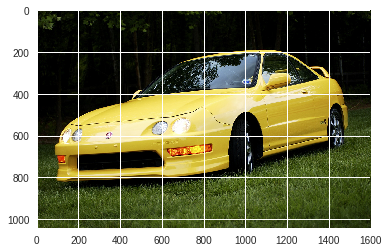

In [94]:
img = plt.imread(f'{PATH}train/Acura Integra Type R 2001/{files[3]}')
plt.imshow(img);

Here is how the raw data looks like

In [95]:
img.shape

(1043, 1600, 3)

In [96]:
img[:4,:4]

array([[[14, 24,  0],
        [15, 25,  0],
        [16, 26,  1],
        [22, 32,  7]],

       [[15, 23,  0],
        [16, 24,  0],
        [16, 24,  1],
        [18, 26,  3]],

       [[15, 23,  0],
        [14, 22,  1],
        [13, 21,  0],
        [13, 20,  2]],

       [[17, 22,  2],
        [15, 19,  2],
        [12, 16,  0],
        [11, 15,  0]]], dtype=uint8)

In [0]:
#arch = vgg16
arch = resnet34
#arch = resnext50
#arch = resnext101_64
sz = 224
bs = 64

In [0]:
# fast.ai functions to initialize transform and data loader objects
tfms=tfms_from_model(arch, sz)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs, num_workers=4)

In [100]:
#pick first image just for viewing
pic = PATH + data.trn_ds.fnames[0]; pic

'car_data/train/AM General Hummer SUV 2000/06833.jpg'

In [101]:
!ls

anno_test.csv  anno_train.csv  car_data  car_data.zip  kaggle.json  names.csv


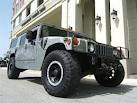

In [102]:
img = PIL.Image.open(pic); img
#img = PIL.Image.open(f'{pic}');
#img = plt.imread(pic)
#plt.imshow(img);

In [0]:
# create python data dictionary {}, path/file and image size(x,y)
# ps very long processing time
e_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [0]:
e_d

In [0]:
#!pip3 list

In [0]:
#redefine zip, after ZipFile breaks it
def zip(*iterables):
    # zip('ABCD', 'xy') --> Ax By
    sentinel = object()
    iterators = [iter(it) for it in iterables]
    while iterators:
        result = []
        for it in iterators:
            elem = next(it, sentinel)
            if elem is sentinel:
                return
            result.append(elem)
        yield tuple(result)

In [0]:
import os
row_sz, col_sz = list(zip(*e_d.values()))

In [119]:
row_sz[:5]

(137, 720, 500, 1024, 2405)

In [0]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [139]:
col_sz[:5]

array([ 103,  303,  375,  743, 1600])

In [140]:
# find few row/col ratios
row_sz[:5]/col_sz[:5]

array([1.3301 , 2.37624, 1.33333, 1.3782 , 1.50313])

In [122]:
print(min(row_sz), max(row_sz))

78 5616


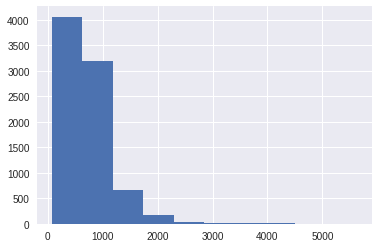

In [123]:
plt.hist(row_sz);

(array([  71.,  129.,  807.,  640.,  452.,  924.,  337., 2085.,  216.,  260.]),
 array([ 78. , 150.1, 222.2, 294.3, 366.4, 438.5, 510.6, 582.7, 654.8, 726.9, 799. ]),
 <a list of 10 Patch objects>)

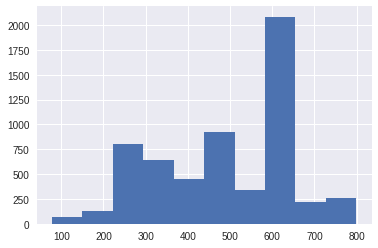

In [126]:
plt.hist(row_sz[row_sz < 800])

In [128]:
# again, list total number of classes, and list them all
# os.list dir sorting depends on OS dependent file indexing, so leaving it as it is

classes = os.listdir(f'{PATH}/train')
classes.sort()
print("Class Total Count: ", len(classes))
print(classes)

Class Total Count:  196
['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 

In [129]:
# parse all classes and assemble python list object []
# each list element will contain array of files names of a class

all_images_class = [os.listdir(f'{PATH}/train/'+c) for c in classes]
#int_to_classes = {i:classes[i] for i in range(len(classes))}
#classes_to_int = {classes[i]:i for i in range(len(classes))}
print("Classes: ",len(all_images_class) )

Classes:  196


In [130]:
# create python data dictionary {}, with key="text", and value as length(of size) of containing list object array (1D)
# gives histogram like file count for each class
dataDict= {"n_images": [len(x) for x in all_images_class]}
print("file count in each class: ",dataDict)
trainFiles = 0
for x in all_images_class:
  trainFiles = trainFiles+len(x)
print(" Total Train Files: ", trainFiles)

file count in each class:  {'n_images': [45, 45, 32, 43, 42, 41, 39, 45, 41, 33, 38, 41, 43, 41, 43, 37, 45, 40, 42, 43, 46, 41, 40, 43, 44, 36, 41, 43, 42, 44, 34, 45, 41, 41, 39, 42, 42, 41, 39, 45, 46, 35, 37, 36, 33, 44, 42, 43, 35, 38, 43, 45, 41, 45, 45, 42, 40, 38, 47, 30, 35, 37, 43, 39, 45, 45, 43, 44, 40, 44, 38, 44, 37, 40, 44, 49, 44, 43, 45, 41, 38, 45, 42, 41, 44, 39, 42, 41, 39, 41, 46, 44, 44, 40, 43, 44, 40, 46, 28, 34, 40, 43, 39, 42, 44, 38, 43, 45, 45, 43, 42, 43, 45, 44, 46, 45, 42, 45, 40, 68, 42, 43, 45, 44, 39, 39, 39, 41, 42, 24, 42, 42, 43, 44, 42, 34, 40, 44, 41, 42, 34, 33, 40, 47, 43, 45, 45, 44, 43, 44, 45, 36, 36, 43, 43, 39, 37, 29, 36, 44, 48, 46, 44, 45, 37, 41, 48, 46, 44, 42, 39, 44, 44, 41, 39, 31, 44, 42, 45, 43, 38, 46, 42, 41, 39, 41, 44, 44, 39, 43, 46, 43, 46, 42, 43, 40]}
 Total Train Files:  8144


In [0]:
# assemble panda Dataframe {class pandas.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)}
# Train Data set
df = pd.DataFrame(dataDict, index=classes)
df.index.name = "Cars"

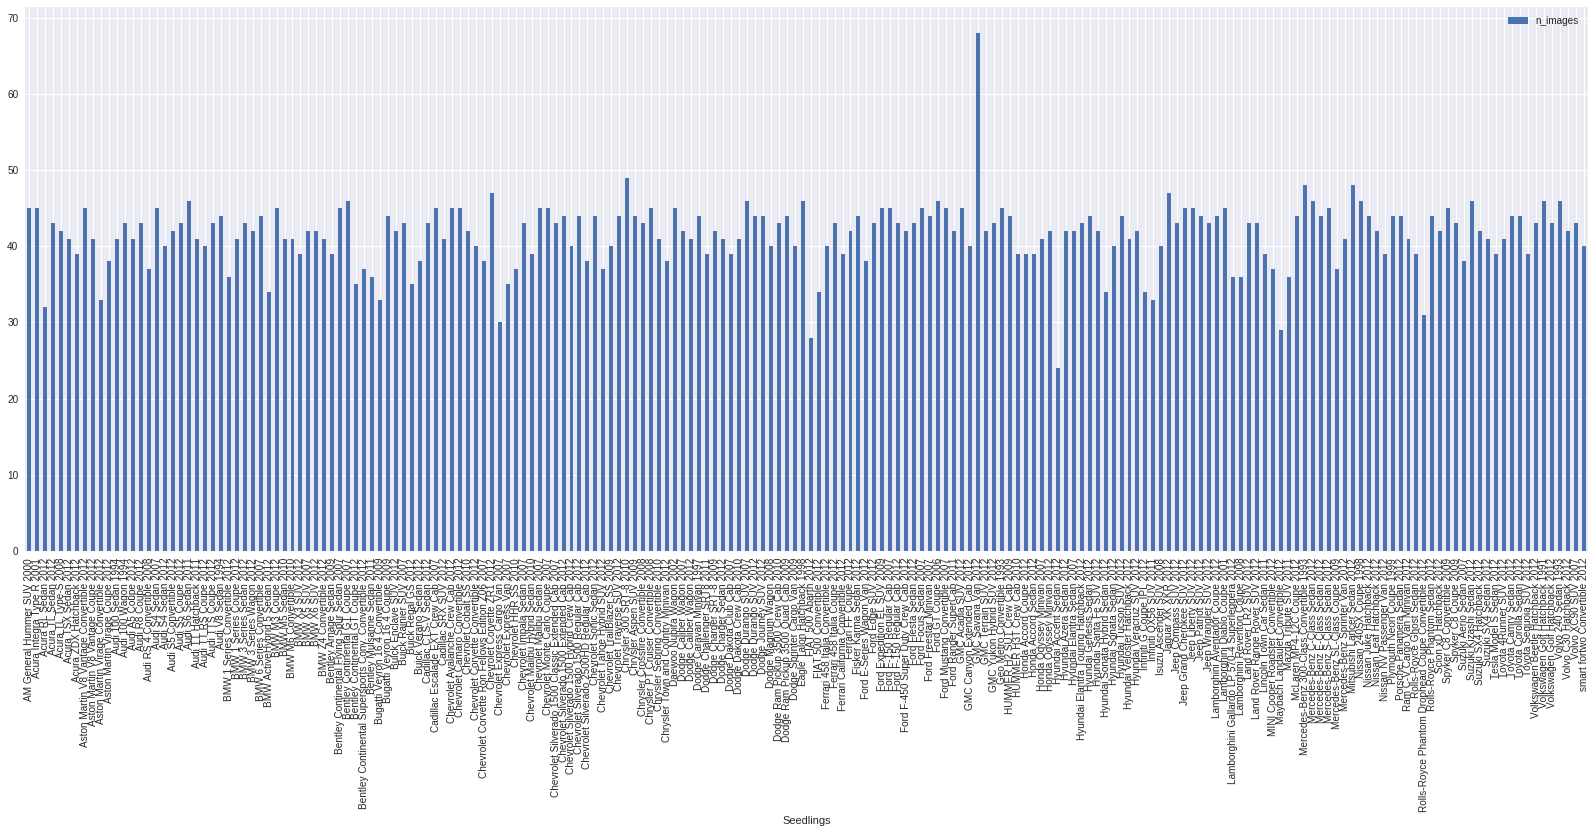

In [137]:
df.plot(kind="bar", grid=True,figsize=(28,10))

##Review: easy steps to train a world-class image classifier

 *   precompute=True
 *   Use lr_find() to find highest learning rate where loss is still clearly improving
 *   Train last layer from precomputed activations for 1-2 epochs
 *   Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
 *   Unfreeze all layers
 *   Set earlier layers to 3x-10x lower learning rate than next higher layer
 *   Use lr_find() again
 *   Train full network with cycle_mult=2 until over-fitting


## Initial Model

In [0]:
#arch = vgg16
arch = resnet34
#arch = resnext50
#arch = resnext101_64
sz = 224
bs = 64

In [0]:
#The transforms downsize the images to 224 or 299. Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time.

def get_data(sz, bs): # sz: image size, bs: batch size
    #tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    tfms=tfms_from_model(arch, sz)
    data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs, num_workers=4)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 180 first saves time

#Source:   
    def resize(self, targ, new_path):
        new_ds = []
        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
        else: dls += [None,None]
        t = tqdm_notebook(dls)
        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
        t.close()
        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

In [146]:
# Precompute
data = get_data(sz, bs)

In [147]:
# Get initial predictions on pre-trained network, just training last layers
# model trained on ImageNet (1.2 million images and 1000 classes) as a starting point.
# resnet34 is a version of the model that won the 2015 ImageNet competition. 
# precompute shall speed up the process

learn = ConvLearner.pretrained(arch, data)
%time learn.fit(0.01, 5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 26473124.46it/s]


epoch      trn_loss   val_loss   accuracy   
    0      4.826323   4.051567   0.141773  
    1      3.938276   3.460496   0.238901  
    2      3.409989   3.097781   0.293371  
    3      3.070689   2.85672    0.338018  
    4      2.791417   2.663796   0.362268  



[array([2.6638]), 0.3622683746692272]

In [0]:
learn.sched.plot_loss()

In [148]:
data.val_y

array([  0,   0,   0, ..., 195, 195, 195])

### Choosing a learning rate
The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [0]:
learn = ConvLearner.pretrained(arch, data)

In [150]:
lrf=learn.lr_find()

 96%|█████████▌| 123/128 [01:02<00:02,  1.73it/s, loss=26.9]

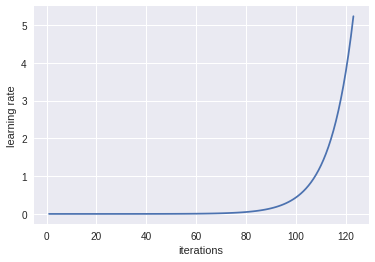

In [151]:
# Our learn object contains an attribute sched that contains our learning rate scheduler, and has some convenient plotting functionality including this one:
learn.sched.plot_lr()

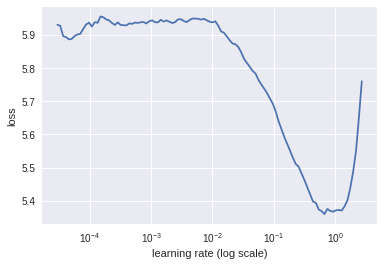

In [155]:
learn.sched.plot()

The loss is still clearly improving at lr=0.1, so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

In [157]:
# selecting new learning rate for 5 epochs
%time learn.fit(0.1, 5)

epoch      trn_loss   val_loss   accuracy   
    0      5.293668   3.509158   0.217386  
    1      4.577749   3.416796   0.245119  
    2      4.218494   3.175345   0.270489  
    3      3.965981   3.100598   0.280189  
    4      3.77596    2.971318   0.296605  


[array([2.97132]), 0.2966048998287729]

In [0]:
learn.sched.plot_loss()

### Augment data set
If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.


In [0]:
from sklearn import metrics

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH,val_name='test', bs=2, tfms=tfms, num_workers=4)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

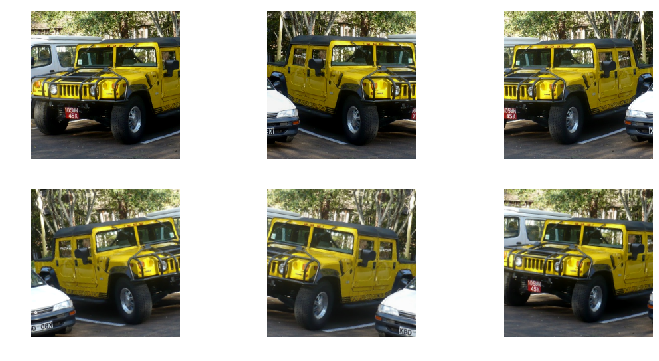

In [163]:
# plot augmented sample image
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [170]:
# Let's create a new data object that includes this augmentation in the transforms.
# By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.
def get_data_transform(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs, num_workers=4)
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 180 first saves time

data = get_data_transform(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In [171]:
%time learn.fit(0.1, 5)

epoch      trn_loss   val_loss   accuracy   
    0      4.03244    3.145749   0.236786  
    1      3.269423   2.750451   0.31215   
    2      2.979742   2.539426   0.356921  
    3      2.701911   2.440841   0.373585  
    4      2.59334    2.369823   0.386643  
CPU times: user 18min 53s, sys: 2min 10s, total: 21min 3s
Wall time: 11min 36s


[array([2.36982]), 0.3866434523810529]

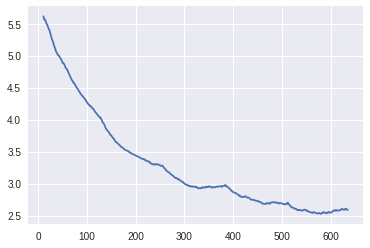

In [172]:
learn.sched.plot_loss()

In [173]:
# cycle_len - learning rate annealing used by stochastic gradient descent with restarts (SGDR),
%time learn.fit(0.1, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      2.234998   2.186613   0.429424  
    1      2.183369   2.163359   0.441612  
    2      2.152481   2.138915   0.44497   
CPU times: user 11min 19s, sys: 1min 17s, total: 12min 37s
Wall time: 6min 57s


[array([2.13891]), 0.444969531056478]

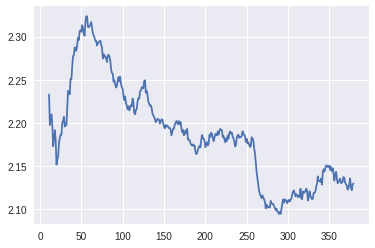

In [174]:
learn.sched.plot_loss()

What is that cycle_len parameter? What we've done here is used a technique called stochastic gradient descent with restarts (SGDR), a variant of learning rate annealing, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by cycle_len, and the number of times this happens is refered to as the number of cycles, and is what we're actually passing as the 2nd parameter to fit(). So here's what our actual learning rates looked like:


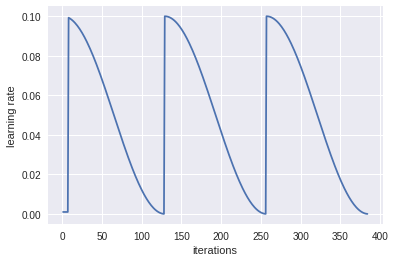

In [175]:
learn.sched.plot_lr()

In [0]:
# if Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).

# in our case we are skipping this
# learn = ConvLearner.pretrained(arch, data)
# learn.fit(1e-1, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

In [0]:
learn.save('224_pre')

In [0]:
learn.load('224_pre')

###Fine-tuning and differential learning rate annealing
Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) unfreeze().


In [0]:
learn.unfreeze()
# keep batch normalization moving avg not be updated. Very important!!!
#learn.ns_freeze(True)

ote that the other layers have already been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

In [182]:
lr=np.array([0.001, 0.01, 0.1])
% time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      1.912892   1.379114   0.631762  
    1      1.612178   1.197699   0.661361  
    2      0.936085   0.920905   0.735356  
    3      1.26949    1.279353   0.640468  
    4      0.87174    0.946288   0.73461   
    5      0.527076   0.726839   0.79219   
    6      0.365687   0.693536   0.802139  
CPU times: user 31min 2s, sys: 4min 33s, total: 35min 36s
Wall time: 21min 24s


[array([0.69354]), 0.8021390375517565]

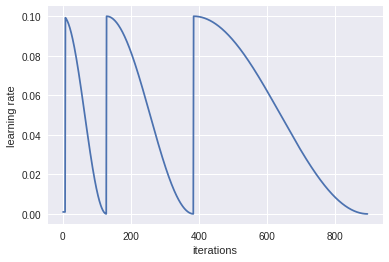

In [183]:
#Another trick we've used here is adding the cycle_mult parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the final layers. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set lr=np.array([1e-4,1e-3,1e-2]).

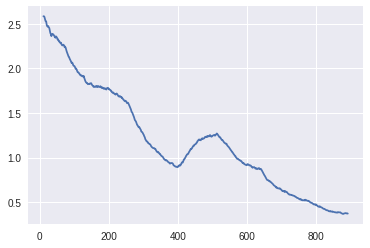

In [184]:
learn.sched.plot_loss()

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

###Increase image size

In [0]:
sz = 400

In [0]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs, num_workers=4)

In [0]:
#data = get_data(sz)
#data = data.resize(int(sz*1.3), 'tmp')

In [0]:
learn.set_data(get_data(sz))
learn.freeze()

 94%|█████████▍| 120/128 [04:48<00:13,  1.71s/it, loss=5.24]

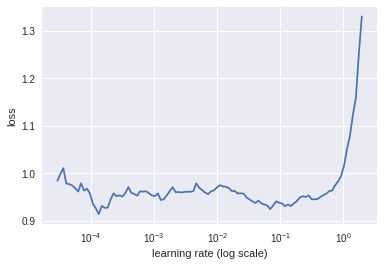

In [197]:
lrf=learn.lr_find()
learn.sched.plot()

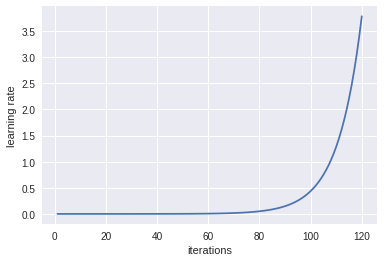

In [198]:
learn.sched.plot_lr()

In [201]:
# choose new learning rate, and run fit
lr=0.05
%time learn.fit(lr, 3)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.9 µs


epoch      trn_loss   val_loss   accuracy   
    0      0.833821   0.88421    0.762467  
    1      0.757263   0.833574   0.774531  
    2      0.686919   0.81259    0.779381  


[array([0.81259]), 0.7793806739120901]

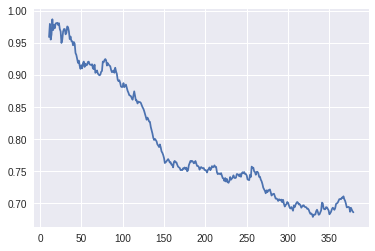

In [202]:
learn.sched.plot_loss()

In [0]:
learn.unfreeze()

In [0]:
lr=np.array([0.0005, 0.005, 0.05])
%time vals_s2s, ep_vals_s2s = learn.fit(lr, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True) # 1+2+4 = 7 epochs

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


epoch      trn_loss   val_loss   accuracy   
    0      0.561488   0.608906   0.828877  
    1      0.482751   0.598708   0.830742  
    2      0.315186   0.53344    0.851511  
    3      0.350167   0.626543   0.829001  
    4      0.27497    0.552839   0.851635  
    5      0.197944   0.503173   0.865813  


In [0]:
learn.sched.plot_loss()

In [0]:
def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = ep_vals.keys()
    plt.xticks(np.asarray(list(epochs)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    val_losses = [item[1] for item in list(ep_vals.values())]
    plt.plot(epochs, trn_losses, c='b', label='train')
    plt.plot(epochs, val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

In [0]:
plot_ep_vals(ep_vals_s2s)

In [0]:
learn.save(f'{sz}')

###Final Layer fitting with TTA

In [0]:
# frezzing all early layers, and training few more epochs on last layer
learn.freeze()


In [0]:
learn.summary()

In [0]:
#learn.fit(0.1, 3, cycle_len=1)

In [0]:
# Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
#%% time 
#vals_s2s, ep_vals_s2s = learn.fit(0.1, 3, cycle_len=1, cycle_mult=2, get_ep_vals=True) # 1+2+4 = 7 epochs

In [0]:
#learn.sched.plot_loss()


In [0]:
%time log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
learn.save('299_pre')

In [0]:
learn.load('299_pre')

## Analyzing Results
### Confusion matrix

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [0]:
plot_confusion_matrix(cm, data.classes)

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [0]:
# This is the label for a val data
data.val_y

In [0]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

In [0]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

In [0]:
log_preds[:10]

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [0]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [0]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [0]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

In [0]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

In [0]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

In [0]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [0]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [0]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [0]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.